In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat
from sklearn import linear_model as lm
from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


# Séries Temporais
No contexto de análise e ciência de dados, séries temporais são dados observados de forma sequencial, em intervalos regulares ou irregulares. Muitas vezes esses dados são resultado de agregações feitas por um campo de data: podemos construir a série temporal do número de itens vendidos pelo Olist por dia, ou então o número de ataques de tubarão for mês.

# Dataset

Vamos continuar a análise do conjunto de dados de cancelamentos de reservas em 2 hotéis europeus. No entanto, enquanto no case de sábado passado fizemos uma análise baseada no dado transacional (cada individuo de nossa tabela era uma reserva) hoje agregaremos este dado e analisaremos o resultado agregado diário para um dos hotéis.

Primeiro vamos carregar o conjunto de dados de hotéis e transformar a informação de data em campos datetime. Isso nos permitirá calcular a data na qual a reserva foi feita.

In [3]:
tb_hotel = pd.read_csv("data/tb_hotel_bookings_full.csv")
tb_hotel["arrival_dt"] = pd.to_datetime(tb_hotel["arrival_date"])
tb_hotel["update_dt"] = pd.to_datetime(tb_hotel["reservation_status_date"])
tb_hotel["reserva_dt"] = tb_hotel["arrival_dt"] - pd.to_timedelta(
    tb_hotel["lead_time"], unit="d"
)


Para construir a série temporal de cancelamentos e reservas precisamos decidir por qual campo de data agregaremos nossos dados:

1. **Data de Chegada**
1. **Data da Reserva**
1. **Data da Última Atualização da Reserva**

Essa opção é algo comum quando construímos séries temporais (no âmbito de produtos por exemplo podemos ver as datas de compra, de faturamento e de entrega por exemplo). Por enquanto limitaremos a análise à **data de chegada**.

In [4]:
tb_resort = tb_hotel[tb_hotel["hotel"] == "Resort Hotel"]
tb_resort_ts = (
    tb_resort.groupby("arrival_dt")
    .agg(
        num_reservas=pd.NamedAgg("id_booking", "count"),
        num_canceladas=pd.NamedAgg("is_canceled", "sum"),
    )
    .reset_index()
)
tb_resort_ts["per_canceladas"] = (
    tb_resort_ts["num_canceladas"] / tb_resort_ts["num_reservas"]
)


A forma mais comum de visualizar dados de série temporal é através de **lineplots** onde o tempo é colocado no eixo X e as variáveis a serem analisadas no eixo Y.

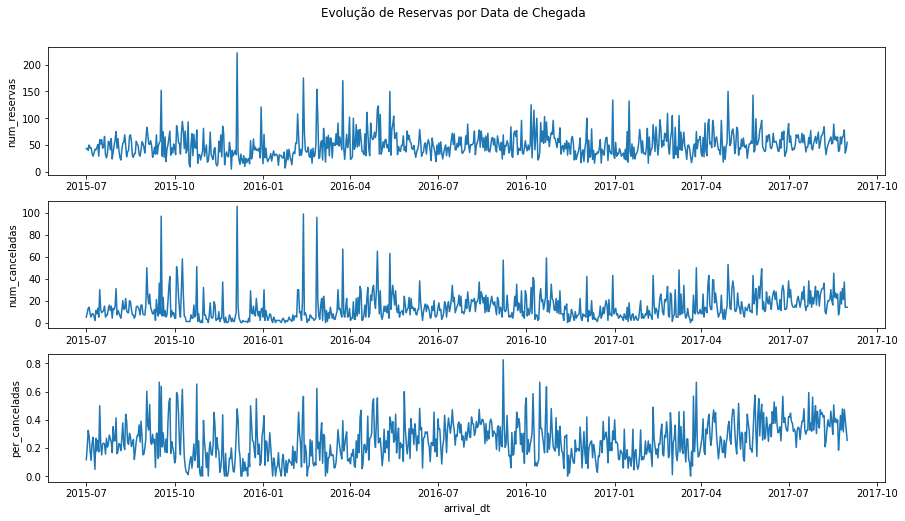

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_reservas", ax=ax[0])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_canceladas", ax=ax[1])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas", ax=ax[2])
ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95);


## Train & Test para séries temporais
A nossa estratégia tradicional para divisão de um dataset em train e test não funciona em séries temporais: como elas são definidas pela sequencialidade das observações, remover pontos aleatórios de dentro da série seria estranho... A forma mais simples e tradicional de se fazer essa divisão é selecionando pontos no fim da série como nosso conjunto teste. No exemplo acima optei por formar o conjunto de train a partir dos dois primeiros anos continuos que temos na série (veremos porque quando olharmos componentes sazonais).

In [7]:
tb_resort_ts["arrival_dt"].describe()


/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_65110/944963118.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tb_resort_ts["arrival_dt"].describe()


count                     793
unique                    793
top       2015-07-01 00:00:00
freq                        1
first     2015-07-01 00:00:00
last      2017-08-31 00:00:00
Name: arrival_dt, dtype: object

Ao invés de realizar a transformação agora, vamos definir uma função que realiza essa divisão para nós. Dessa forma não precisamos replicar nosso feature engineering em 2 datasets o tempo todo.

In [10]:
def split_hotel_ts(hotel_data):
    train_data = hotel_data[hotel_data["arrival_dt"] < "2017-08-01"].copy()
    test_data = hotel_data[hotel_data["arrival_dt"] >= "2017-08-01"].copy()
    return train_data, test_data


# Decomposição TCSI

A forma mais tradicional de se analisar um série temporal é através da decomposição TCSI:

1. **T - Componente de Tendência (Trend):** representação da evolução a longo prazo da série (*a taxa de cancelamento está crescendo ou caindo?*)
1. **C - Componente Ciclico (Cyclic)** representação da evolução ciclica não periódicas (*depois de altas de cancelamento tenho baixas?*)
1. **S - Componente Sazonal (Seasonal)** representação da peridiocidade sazonal (ciclo regular) (*temos mais cancelamento para reservas em junho? ou para reservas de segunda-feira? ou da última semana do mês?*)
1. **I - Componente de Ruído (Irregular/Noise)** o que não é representado pelos três componentes acima.

## Componente de Tendência (Trend)

In [11]:
tb_resort_ts["t_dias"] = (
    tb_resort_ts["arrival_dt"] - min(tb_resort_ts["arrival_dt"])
).dt.total_seconds() / (24 * 60 * 60)
tb_resort_ts.head()

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
0,2015-07-01,43,5,0.116279,0.0
1,2015-07-02,44,9,0.204545,1.0
2,2015-07-03,40,13,0.325000,2.0
3,2015-07-04,50,14,0.280000,3.0
4,2015-07-05,45,8,0.177778,4.0


### Estimativa de tendência linear

In [12]:
train_data, test_data = split_hotel_ts(tb_resort_ts)
trend_fit = lm.LinearRegression()
trend_fit.fit(train_data[["t_dias"]], train_data["per_canceladas"])


LinearRegression()

In [70]:
trend_fit.coef_

array([0.00013428])

In [13]:
tb_resort_ts["pred_trend_linear"] = trend_fit.predict(tb_resort_ts[["t_dias"]])


Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

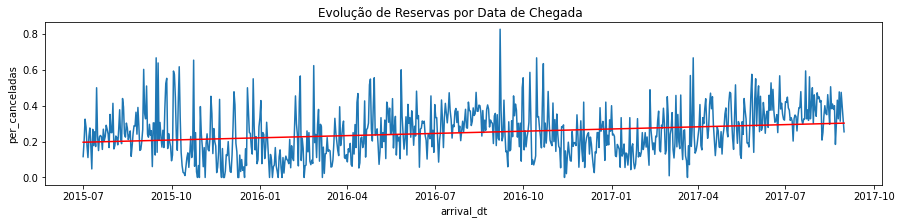

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="pred_trend_linear", color="red")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Componente Cíclico (Cycle)

Como os ciclos representam variações não-periódicas é dificil separa-los da avaliação de tendência (principalmente em séries curtas). Vamos utilizar três técnicas para estimar variações em relação a tendência.

### Tendência Polinomial

In [20]:
from sklearn.preprocessing import PolynomialFeatures


In [44]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])


PolynomialFeatures()

In [45]:
poly_trans.n_output_features_


3

In [46]:
tb_resort_ts

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear
0,2015-07-01,43,5,0.116279,0.0,0.196375
1,2015-07-02,44,9,0.204545,1.0,0.196509
2,2015-07-03,40,13,0.325000,2.0,0.196644
3,2015-07-04,50,14,0.280000,3.0,0.196778
4,2015-07-05,45,8,0.177778,4.0,0.196912
...,...,...,...,...,...,...
788,2017-08-27,67,21,0.313433,788.0,0.302185
789,2017-08-28,78,37,0.474359,789.0,0.302319
790,2017-08-29,35,14,0.400000,790.0,0.302453
791,2017-08-30,42,14,0.333333,791.0,0.302588


In [47]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        )

,P0,P1,P2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,1.0,2.0,4.0
3,1.0,3.0,9.0
4,1.0,4.0,16.0
...,...,...,...
788,1.0,788.0,620944.0
789,1.0,789.0,622521.0
790,1.0,790.0,624100.0
791,1.0,791.0,625681.0


In [48]:
poly_trans.transform(tb_resort_ts[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.90000e+02, 6.24100e+05],
       [1.00000e+00, 7.91000e+02, 6.25681e+05],
       [1.00000e+00, 7.92000e+02, 6.27264e+05]])

In [49]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_resort_ts_p = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_p.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,P0,P1,P2
0,2015-07-01,43,5,0.116279,0.0,0.196375,1.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,1.0,1.0,1.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,1.0,2.0,4.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,1.0,3.0,9.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

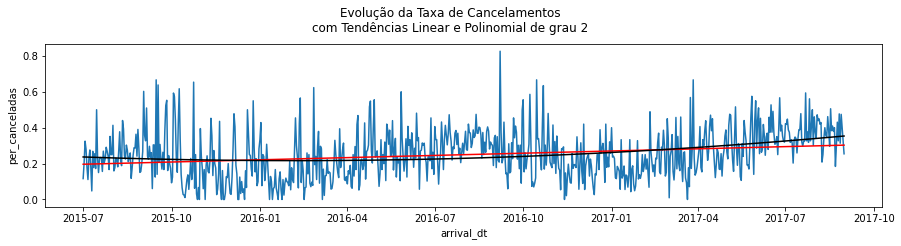

In [50]:
train_data, test_data = split_hotel_ts(tb_resort_ts_p)

poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["per_canceladas"])



tb_resort_ts_p["pred_trend_poly"] = poly_trend_fit.predict(tb_resort_ts_p[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [43]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.21


### B-Splines

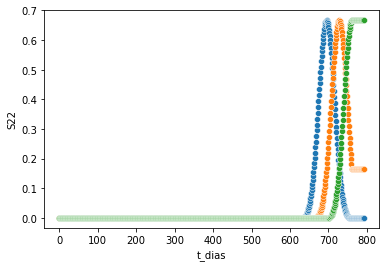

In [79]:
spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_b.head()
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S22');
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S23');
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S24');


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

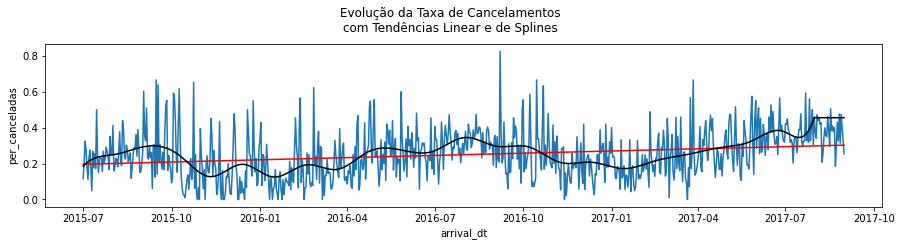

In [80]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spline_fit = lm.LinearRegression()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [81]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline: 0.11


O que podemos melhorar aqui?

Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

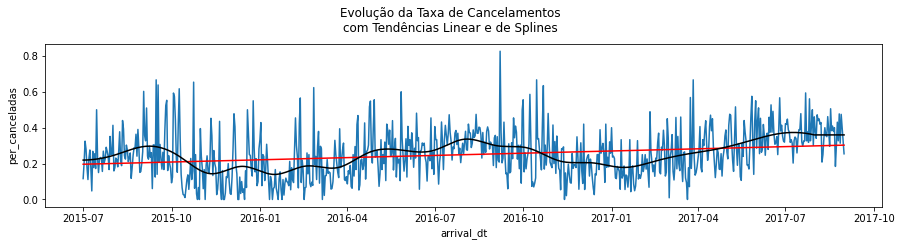

In [82]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spline_fit = lm.Ridge()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [83]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline.: 0.08


## Componente Sazonal

### Variáveis Sazonais Contínuas

In [84]:
tb_resort_ts_b["s_semana"] = np.sin(tb_resort_ts_b["t_dias"] / (7 / np.pi))
tb_resort_ts_b["c_semana"] = np.cos(tb_resort_ts_b["t_dias"] / (7 / np.pi))

tb_resort_ts_b["s_mes"] = np.sin(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))
tb_resort_ts_b["c_mes"] = np.cos(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))

tb_resort_ts_b["s_ano"] = np.sin(tb_resort_ts_b["t_dias"] / (365 / np.pi))
tb_resort_ts_b["c_ano"] = np.cos(tb_resort_ts_b["t_dias"] / (365 / np.pi))


Text(0.5, 0.95, 'Variáveis Contínuas Ciclicas')

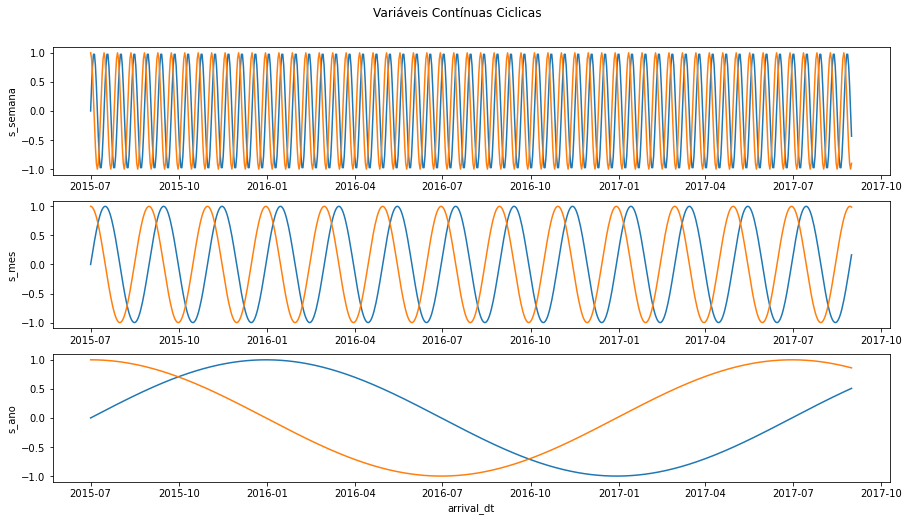

In [85]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_semana", ax=ax[0])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_semana", ax=ax[0])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_mes", ax=ax[1])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_mes", ax=ax[1])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_ano", ax=ax[2])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_ano", ax=ax[2])

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Variáveis Contínuas Ciclicas", y=0.95)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

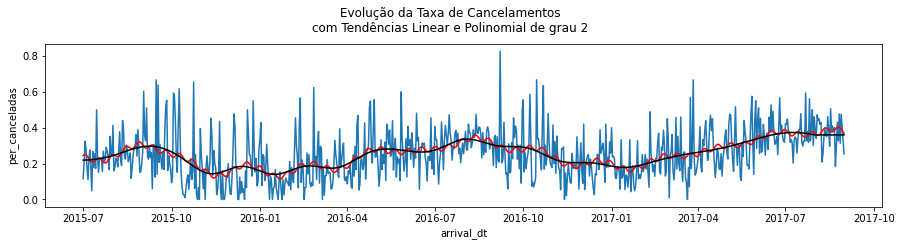

In [86]:
c_names = ["c_semana", "s_semana", "c_mes", "s_mes", "c_ano", "s_ano"]
spl_cycle = spl_names + c_names
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spl_cycle_fit = lm.Ridge()
spl_cycle_fit.fit(train_data[spl_cycle], train_data["per_canceladas"])
tb_resort_ts_b["pred_cycle_poly"] = spl_cycle_fit.predict(tb_resort_ts_b[spl_cycle])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_cycle_poly", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [87]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
test_data["pred_trend_cycle"] = spl_cycle_fit.predict(test_data[spl_cycle])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spline = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_cycle"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_spline, 2)}")
print(f"Trend + Cycle: {round(rmse_cycle, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.08
Trend + Cycle: 0.08


### Variáveis Sazonais Dummy

In [88]:
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)


In [89]:
tb_resort_ts_b[["mes", "dia_semana"]]


,mes,dia_semana
0,7,2
1,7,3
2,7,4
3,7,5
4,7,6
...,...,...
788,8,6
789,8,0
790,8,1
791,8,2


In [90]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
tb_resort_ts_d = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


In [91]:
tb_resort_ts_d.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,S0,S1,S2,S3,...,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2015-07-01,43,5,0.116279,0.0,0.196375,0.166667,0.666667,0.166667,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,0.152007,0.665767,0.182221,0.000005,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,0.138233,0.663123,0.198607,0.000037,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,0.125318,0.658818,0.215740,0.000124,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,0.113233,0.652935,0.233538,0.000294,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

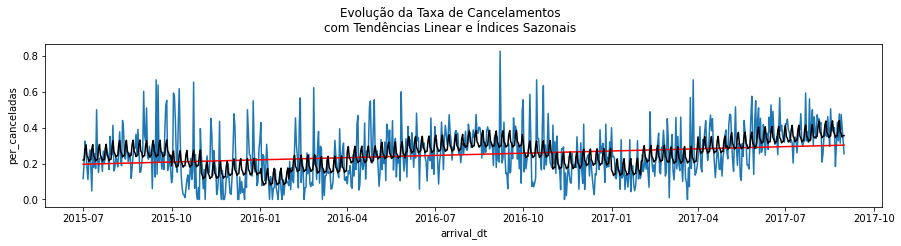

In [106]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d)
dummy_names = list(ohe_fit.get_feature_names_out())
var_names = ["t_dias"] + dummy_names
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


In [105]:
spl_names

['S0',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S18',
 'S19',
 'S20',
 'S21',
 'S22',
 'S23',
 'S24',
 'S25']

In [ ]:
season_trend_fit.coef_

In [97]:
pd.DataFrame(season_trend_fit.coef_, index=train_data[var_names].columns)

,0
t_dias,0.000148
mes_10,0.112687
mes_11,0.044992
mes_12,0.059357
mes_2,0.069480
mes_3,0.058571
mes_4,0.110230
mes_5,0.128891
mes_6,0.156167
mes_7,0.160118


In [93]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")


Trend Lin.: 0.11
Trend + Season: 0.07


In [98]:
train_data.columns


Index(['arrival_dt', 'num_reservas', 'num_canceladas', 'per_canceladas',
       't_dias', 'pred_trend_linear', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6',
       'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16',
       'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25',
       'pred_spline', 's_semana', 'c_semana', 's_mes', 'c_mes', 's_ano',
       'c_ano', 'pred_cycle_poly', 'mes', 'dia_semana', 'mes_10', 'mes_11',
       'mes_12', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8',
       'mes_9', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4',
       'dia_semana_5', 'dia_semana_6', 'pred_trend_season'],
      dtype='object')

In [99]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["per_canceladas"]
y_test = test_data["per_canceladas"]
scaler = StandardScaler()
scaler.fit(X_train)
cat_fit = cat.CatBoostRegressor(iterations=20000, depth=9, od_type="Iter", od_wait=1500)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)


Learning rate set to 0.006771
0:	learn: 0.1354049	test: 0.1472045	best: 0.1472045 (0)	total: 70.1ms	remaining: 23m 22s
1:	learn: 0.1351916	test: 0.1465726	best: 0.1465726 (1)	total: 75.2ms	remaining: 12m 32s
2:	learn: 0.1350027	test: 0.1459287	best: 0.1459287 (2)	total: 81.6ms	remaining: 9m 3s
3:	learn: 0.1348178	test: 0.1457950	best: 0.1457950 (3)	total: 86.7ms	remaining: 7m 13s
4:	learn: 0.1346169	test: 0.1453172	best: 0.1453172 (4)	total: 93.7ms	remaining: 6m 14s
5:	learn: 0.1344280	test: 0.1447238	best: 0.1447238 (5)	total: 98.6ms	remaining: 5m 28s
6:	learn: 0.1342264	test: 0.1441331	best: 0.1441331 (6)	total: 101ms	remaining: 4m 49s
7:	learn: 0.1340382	test: 0.1444065	best: 0.1441331 (6)	total: 107ms	remaining: 4m 26s
8:	learn: 0.1338542	test: 0.1439285	best: 0.1439285 (8)	total: 109ms	remaining: 4m 3s
9:	learn: 0.1336657	test: 0.1433108	best: 0.1433108 (9)	total: 114ms	remaining: 3m 48s
10:	learn: 0.1334785	test: 0.1427690	best: 0.1427690 (10)	total: 119ms	remaining: 3m 36s
11:	l

94:	learn: 0.1219564	test: 0.1136094	best: 0.1136094 (94)	total: 586ms	remaining: 2m 2s
95:	learn: 0.1218398	test: 0.1133054	best: 0.1133054 (95)	total: 591ms	remaining: 2m 2s
96:	learn: 0.1217569	test: 0.1129440	best: 0.1129440 (96)	total: 597ms	remaining: 2m 2s
97:	learn: 0.1216428	test: 0.1126385	best: 0.1126385 (97)	total: 603ms	remaining: 2m 2s
98:	learn: 0.1215461	test: 0.1123097	best: 0.1123097 (98)	total: 612ms	remaining: 2m 2s
99:	learn: 0.1214701	test: 0.1120763	best: 0.1120763 (99)	total: 618ms	remaining: 2m 2s
100:	learn: 0.1213796	test: 0.1117313	best: 0.1117313 (100)	total: 623ms	remaining: 2m 2s
101:	learn: 0.1212849	test: 0.1114290	best: 0.1114290 (101)	total: 626ms	remaining: 2m 2s
102:	learn: 0.1211941	test: 0.1111185	best: 0.1111185 (102)	total: 632ms	remaining: 2m 2s
103:	learn: 0.1210800	test: 0.1109485	best: 0.1109485 (103)	total: 640ms	remaining: 2m 2s
104:	learn: 0.1209705	test: 0.1106533	best: 0.1106533 (104)	total: 648ms	remaining: 2m 2s
105:	learn: 0.1208654	

209:	learn: 0.1137310	test: 0.0929340	best: 0.0929340 (209)	total: 1.38s	remaining: 2m 10s
210:	learn: 0.1136902	test: 0.0928862	best: 0.0928862 (210)	total: 1.39s	remaining: 2m 10s
211:	learn: 0.1136265	test: 0.0928145	best: 0.0928145 (211)	total: 1.4s	remaining: 2m 10s
212:	learn: 0.1135615	test: 0.0927993	best: 0.0927993 (212)	total: 1.4s	remaining: 2m 10s
213:	learn: 0.1135054	test: 0.0927651	best: 0.0927651 (213)	total: 1.41s	remaining: 2m 9s
214:	learn: 0.1134400	test: 0.0926510	best: 0.0926510 (214)	total: 1.41s	remaining: 2m 9s
215:	learn: 0.1134035	test: 0.0924988	best: 0.0924988 (215)	total: 1.42s	remaining: 2m 9s
216:	learn: 0.1133476	test: 0.0923527	best: 0.0923527 (216)	total: 1.42s	remaining: 2m 9s
217:	learn: 0.1133076	test: 0.0922027	best: 0.0922027 (217)	total: 1.43s	remaining: 2m 9s
218:	learn: 0.1132562	test: 0.0921348	best: 0.0921348 (218)	total: 1.44s	remaining: 2m 9s
219:	learn: 0.1132237	test: 0.0918782	best: 0.0918782 (219)	total: 1.44s	remaining: 2m 9s
220:	lea

314:	learn: 0.1092756	test: 0.0852827	best: 0.0852827 (314)	total: 1.97s	remaining: 2m 3s
315:	learn: 0.1092423	test: 0.0851953	best: 0.0851953 (315)	total: 1.98s	remaining: 2m 3s
316:	learn: 0.1092197	test: 0.0851953	best: 0.0851953 (315)	total: 1.98s	remaining: 2m 3s
317:	learn: 0.1091917	test: 0.0852270	best: 0.0851953 (315)	total: 1.99s	remaining: 2m 3s
318:	learn: 0.1091362	test: 0.0851758	best: 0.0851758 (318)	total: 2s	remaining: 2m 3s
319:	learn: 0.1091041	test: 0.0851295	best: 0.0851295 (319)	total: 2s	remaining: 2m 3s
320:	learn: 0.1090630	test: 0.0850939	best: 0.0850939 (320)	total: 2.01s	remaining: 2m 3s
321:	learn: 0.1090411	test: 0.0850289	best: 0.0850289 (321)	total: 2.02s	remaining: 2m 3s
322:	learn: 0.1090071	test: 0.0850099	best: 0.0850099 (322)	total: 2.03s	remaining: 2m 3s
323:	learn: 0.1089699	test: 0.0849209	best: 0.0849209 (323)	total: 2.03s	remaining: 2m 3s
324:	learn: 0.1089556	test: 0.0848059	best: 0.0848059 (324)	total: 2.04s	remaining: 2m 3s
325:	learn: 0.10

419:	learn: 0.1061641	test: 0.0817811	best: 0.0817811 (419)	total: 2.56s	remaining: 1m 59s
420:	learn: 0.1061466	test: 0.0817036	best: 0.0817036 (420)	total: 2.57s	remaining: 1m 59s
421:	learn: 0.1061380	test: 0.0817191	best: 0.0817036 (420)	total: 2.57s	remaining: 1m 59s
422:	learn: 0.1061189	test: 0.0817224	best: 0.0817036 (420)	total: 2.58s	remaining: 1m 59s
423:	learn: 0.1060937	test: 0.0817281	best: 0.0817036 (420)	total: 2.58s	remaining: 1m 59s
424:	learn: 0.1060659	test: 0.0816925	best: 0.0816925 (424)	total: 2.59s	remaining: 1m 59s
425:	learn: 0.1060337	test: 0.0816612	best: 0.0816612 (425)	total: 2.6s	remaining: 1m 59s
426:	learn: 0.1059964	test: 0.0817102	best: 0.0816612 (425)	total: 2.6s	remaining: 1m 59s
427:	learn: 0.1059640	test: 0.0816965	best: 0.0816612 (425)	total: 2.6s	remaining: 1m 59s
428:	learn: 0.1059263	test: 0.0816269	best: 0.0816269 (428)	total: 2.61s	remaining: 1m 59s
429:	learn: 0.1058929	test: 0.0816268	best: 0.0816268 (429)	total: 2.62s	remaining: 1m 59s
43

519:	learn: 0.1036434	test: 0.0800654	best: 0.0800407 (518)	total: 3.15s	remaining: 1m 58s
520:	learn: 0.1036261	test: 0.0800468	best: 0.0800407 (518)	total: 3.16s	remaining: 1m 58s
521:	learn: 0.1036021	test: 0.0800346	best: 0.0800346 (521)	total: 3.16s	remaining: 1m 57s
522:	learn: 0.1035846	test: 0.0799766	best: 0.0799766 (522)	total: 3.17s	remaining: 1m 57s
523:	learn: 0.1035734	test: 0.0799454	best: 0.0799454 (523)	total: 3.17s	remaining: 1m 57s
524:	learn: 0.1035520	test: 0.0799457	best: 0.0799454 (523)	total: 3.18s	remaining: 1m 57s
525:	learn: 0.1035315	test: 0.0799400	best: 0.0799400 (525)	total: 3.19s	remaining: 1m 57s
526:	learn: 0.1035160	test: 0.0799436	best: 0.0799400 (525)	total: 3.19s	remaining: 1m 57s
527:	learn: 0.1035005	test: 0.0799398	best: 0.0799398 (527)	total: 3.2s	remaining: 1m 57s
528:	learn: 0.1034861	test: 0.0799337	best: 0.0799337 (528)	total: 3.2s	remaining: 1m 57s
529:	learn: 0.1034602	test: 0.0799287	best: 0.0799287 (529)	total: 3.2s	remaining: 1m 57s
53

625:	learn: 0.1014233	test: 0.0788232	best: 0.0788232 (625)	total: 3.74s	remaining: 1m 55s
626:	learn: 0.1014057	test: 0.0788210	best: 0.0788210 (626)	total: 3.75s	remaining: 1m 55s
627:	learn: 0.1013948	test: 0.0788030	best: 0.0788030 (627)	total: 3.75s	remaining: 1m 55s
628:	learn: 0.1013740	test: 0.0787997	best: 0.0787997 (628)	total: 3.76s	remaining: 1m 55s
629:	learn: 0.1013541	test: 0.0787558	best: 0.0787558 (629)	total: 3.77s	remaining: 1m 55s
630:	learn: 0.1013425	test: 0.0787660	best: 0.0787558 (629)	total: 3.77s	remaining: 1m 55s
631:	learn: 0.1013228	test: 0.0787767	best: 0.0787558 (629)	total: 3.78s	remaining: 1m 55s
632:	learn: 0.1013011	test: 0.0787835	best: 0.0787558 (629)	total: 3.78s	remaining: 1m 55s
633:	learn: 0.1012826	test: 0.0787650	best: 0.0787558 (629)	total: 3.79s	remaining: 1m 55s
634:	learn: 0.1012618	test: 0.0787645	best: 0.0787558 (629)	total: 3.79s	remaining: 1m 55s
635:	learn: 0.1012435	test: 0.0787333	best: 0.0787333 (635)	total: 3.8s	remaining: 1m 55s


734:	learn: 0.0993002	test: 0.0782399	best: 0.0782399 (734)	total: 4.33s	remaining: 1m 53s
735:	learn: 0.0992871	test: 0.0782361	best: 0.0782361 (735)	total: 4.33s	remaining: 1m 53s
736:	learn: 0.0992588	test: 0.0782455	best: 0.0782361 (735)	total: 4.34s	remaining: 1m 53s
737:	learn: 0.0992350	test: 0.0782500	best: 0.0782361 (735)	total: 4.34s	remaining: 1m 53s
738:	learn: 0.0992222	test: 0.0782463	best: 0.0782361 (735)	total: 4.35s	remaining: 1m 53s
739:	learn: 0.0992030	test: 0.0782425	best: 0.0782361 (735)	total: 4.36s	remaining: 1m 53s
740:	learn: 0.0991869	test: 0.0782342	best: 0.0782342 (740)	total: 4.37s	remaining: 1m 53s
741:	learn: 0.0991657	test: 0.0782173	best: 0.0782173 (741)	total: 4.37s	remaining: 1m 53s
742:	learn: 0.0991482	test: 0.0782061	best: 0.0782061 (742)	total: 4.38s	remaining: 1m 53s
743:	learn: 0.0991262	test: 0.0782025	best: 0.0782025 (743)	total: 4.38s	remaining: 1m 53s
744:	learn: 0.0991104	test: 0.0781829	best: 0.0781829 (744)	total: 4.39s	remaining: 1m 53s

832:	learn: 0.0975556	test: 0.0775939	best: 0.0775939 (832)	total: 4.92s	remaining: 1m 53s
833:	learn: 0.0975323	test: 0.0775968	best: 0.0775939 (832)	total: 4.93s	remaining: 1m 53s
834:	learn: 0.0975125	test: 0.0775898	best: 0.0775898 (834)	total: 4.94s	remaining: 1m 53s
835:	learn: 0.0974933	test: 0.0775906	best: 0.0775898 (834)	total: 4.95s	remaining: 1m 53s
836:	learn: 0.0974867	test: 0.0775751	best: 0.0775751 (836)	total: 4.96s	remaining: 1m 53s
837:	learn: 0.0974762	test: 0.0775700	best: 0.0775700 (837)	total: 4.96s	remaining: 1m 53s
838:	learn: 0.0974686	test: 0.0775700	best: 0.0775700 (837)	total: 4.97s	remaining: 1m 53s
839:	learn: 0.0974570	test: 0.0775630	best: 0.0775630 (839)	total: 4.99s	remaining: 1m 53s
840:	learn: 0.0974429	test: 0.0775626	best: 0.0775626 (840)	total: 4.99s	remaining: 1m 53s
841:	learn: 0.0974286	test: 0.0775679	best: 0.0775626 (840)	total: 5s	remaining: 1m 53s
842:	learn: 0.0974153	test: 0.0775678	best: 0.0775626 (840)	total: 5s	remaining: 1m 53s
843:	

927:	learn: 0.0959741	test: 0.0773678	best: 0.0773678 (927)	total: 5.52s	remaining: 1m 53s
928:	learn: 0.0959632	test: 0.0773678	best: 0.0773678 (927)	total: 5.53s	remaining: 1m 53s
929:	learn: 0.0959375	test: 0.0773671	best: 0.0773671 (929)	total: 5.53s	remaining: 1m 53s
930:	learn: 0.0959216	test: 0.0773819	best: 0.0773671 (929)	total: 5.54s	remaining: 1m 53s
931:	learn: 0.0959014	test: 0.0773805	best: 0.0773671 (929)	total: 5.55s	remaining: 1m 53s
932:	learn: 0.0958885	test: 0.0773791	best: 0.0773671 (929)	total: 5.56s	remaining: 1m 53s
933:	learn: 0.0958636	test: 0.0773779	best: 0.0773671 (929)	total: 5.56s	remaining: 1m 53s
934:	learn: 0.0958506	test: 0.0773750	best: 0.0773671 (929)	total: 5.57s	remaining: 1m 53s
935:	learn: 0.0958404	test: 0.0773684	best: 0.0773671 (929)	total: 5.58s	remaining: 1m 53s
936:	learn: 0.0958206	test: 0.0773675	best: 0.0773671 (929)	total: 5.58s	remaining: 1m 53s
937:	learn: 0.0957989	test: 0.0773663	best: 0.0773663 (937)	total: 5.59s	remaining: 1m 53s

1026:	learn: 0.0943919	test: 0.0770827	best: 0.0770827 (1026)	total: 6.11s	remaining: 1m 52s
1027:	learn: 0.0943700	test: 0.0770526	best: 0.0770526 (1027)	total: 6.12s	remaining: 1m 52s
1028:	learn: 0.0943486	test: 0.0770576	best: 0.0770526 (1027)	total: 6.12s	remaining: 1m 52s
1029:	learn: 0.0943302	test: 0.0770528	best: 0.0770526 (1027)	total: 6.13s	remaining: 1m 52s
1030:	learn: 0.0943107	test: 0.0770413	best: 0.0770413 (1030)	total: 6.14s	remaining: 1m 52s
1031:	learn: 0.0943032	test: 0.0770416	best: 0.0770413 (1030)	total: 6.14s	remaining: 1m 52s
1032:	learn: 0.0942853	test: 0.0770422	best: 0.0770413 (1030)	total: 6.15s	remaining: 1m 52s
1033:	learn: 0.0942752	test: 0.0770375	best: 0.0770375 (1033)	total: 6.15s	remaining: 1m 52s
1034:	learn: 0.0942520	test: 0.0770055	best: 0.0770055 (1034)	total: 6.16s	remaining: 1m 52s
1035:	learn: 0.0942262	test: 0.0770113	best: 0.0770055 (1034)	total: 6.17s	remaining: 1m 52s
1036:	learn: 0.0942082	test: 0.0770099	best: 0.0770055 (1034)	total: 6

1120:	learn: 0.0928433	test: 0.0770396	best: 0.0770055 (1034)	total: 6.71s	remaining: 1m 52s
1121:	learn: 0.0928294	test: 0.0770318	best: 0.0770055 (1034)	total: 6.71s	remaining: 1m 52s
1122:	learn: 0.0928148	test: 0.0770317	best: 0.0770055 (1034)	total: 6.72s	remaining: 1m 52s
1123:	learn: 0.0928055	test: 0.0770486	best: 0.0770055 (1034)	total: 6.73s	remaining: 1m 52s
1124:	learn: 0.0927891	test: 0.0770481	best: 0.0770055 (1034)	total: 6.73s	remaining: 1m 52s
1125:	learn: 0.0927811	test: 0.0770235	best: 0.0770055 (1034)	total: 6.74s	remaining: 1m 52s
1126:	learn: 0.0927640	test: 0.0770358	best: 0.0770055 (1034)	total: 6.74s	remaining: 1m 52s
1127:	learn: 0.0927409	test: 0.0770356	best: 0.0770055 (1034)	total: 6.75s	remaining: 1m 52s
1128:	learn: 0.0927245	test: 0.0770441	best: 0.0770055 (1034)	total: 6.76s	remaining: 1m 52s
1129:	learn: 0.0927128	test: 0.0770438	best: 0.0770055 (1034)	total: 6.76s	remaining: 1m 52s
1130:	learn: 0.0927038	test: 0.0770184	best: 0.0770055 (1034)	total: 6

1212:	learn: 0.0914183	test: 0.0770104	best: 0.0770055 (1034)	total: 7.31s	remaining: 1m 53s
1213:	learn: 0.0913995	test: 0.0770101	best: 0.0770055 (1034)	total: 7.31s	remaining: 1m 53s
1214:	learn: 0.0913879	test: 0.0770104	best: 0.0770055 (1034)	total: 7.32s	remaining: 1m 53s
1215:	learn: 0.0913744	test: 0.0770099	best: 0.0770055 (1034)	total: 7.32s	remaining: 1m 53s
1216:	learn: 0.0913521	test: 0.0770090	best: 0.0770055 (1034)	total: 7.33s	remaining: 1m 53s
1217:	learn: 0.0913347	test: 0.0770079	best: 0.0770055 (1034)	total: 7.34s	remaining: 1m 53s
1218:	learn: 0.0913196	test: 0.0770061	best: 0.0770055 (1034)	total: 7.34s	remaining: 1m 53s
1219:	learn: 0.0912961	test: 0.0770144	best: 0.0770055 (1034)	total: 7.35s	remaining: 1m 53s
1220:	learn: 0.0912805	test: 0.0770149	best: 0.0770055 (1034)	total: 7.36s	remaining: 1m 53s
1221:	learn: 0.0912718	test: 0.0770151	best: 0.0770055 (1034)	total: 7.36s	remaining: 1m 53s
1222:	learn: 0.0912413	test: 0.0770218	best: 0.0770055 (1034)	total: 7

1307:	learn: 0.0899620	test: 0.0769569	best: 0.0769312 (1279)	total: 7.9s	remaining: 1m 52s
1308:	learn: 0.0899563	test: 0.0769571	best: 0.0769312 (1279)	total: 7.91s	remaining: 1m 52s
1309:	learn: 0.0899433	test: 0.0769565	best: 0.0769312 (1279)	total: 7.91s	remaining: 1m 52s
1310:	learn: 0.0899379	test: 0.0769564	best: 0.0769312 (1279)	total: 7.92s	remaining: 1m 52s
1311:	learn: 0.0899196	test: 0.0769548	best: 0.0769312 (1279)	total: 7.92s	remaining: 1m 52s
1312:	learn: 0.0898971	test: 0.0769550	best: 0.0769312 (1279)	total: 7.93s	remaining: 1m 52s
1313:	learn: 0.0898885	test: 0.0769548	best: 0.0769312 (1279)	total: 7.95s	remaining: 1m 52s
1314:	learn: 0.0898776	test: 0.0769551	best: 0.0769312 (1279)	total: 7.96s	remaining: 1m 53s
1315:	learn: 0.0898693	test: 0.0769547	best: 0.0769312 (1279)	total: 7.96s	remaining: 1m 53s
1316:	learn: 0.0898601	test: 0.0769543	best: 0.0769312 (1279)	total: 7.97s	remaining: 1m 53s
1317:	learn: 0.0898453	test: 0.0769539	best: 0.0769312 (1279)	total: 7.

1415:	learn: 0.0883974	test: 0.0768419	best: 0.0768180 (1383)	total: 8.7s	remaining: 1m 54s
1416:	learn: 0.0883876	test: 0.0768286	best: 0.0768180 (1383)	total: 8.7s	remaining: 1m 54s
1417:	learn: 0.0883632	test: 0.0768294	best: 0.0768180 (1383)	total: 8.71s	remaining: 1m 54s
1418:	learn: 0.0883389	test: 0.0768286	best: 0.0768180 (1383)	total: 8.71s	remaining: 1m 54s
1419:	learn: 0.0883197	test: 0.0768273	best: 0.0768180 (1383)	total: 8.72s	remaining: 1m 54s
1420:	learn: 0.0883078	test: 0.0768274	best: 0.0768180 (1383)	total: 8.73s	remaining: 1m 54s
1421:	learn: 0.0882959	test: 0.0768280	best: 0.0768180 (1383)	total: 8.73s	remaining: 1m 54s
1422:	learn: 0.0882707	test: 0.0767958	best: 0.0767958 (1422)	total: 8.73s	remaining: 1m 54s
1423:	learn: 0.0882653	test: 0.0767957	best: 0.0767957 (1423)	total: 8.74s	remaining: 1m 54s
1424:	learn: 0.0882463	test: 0.0767951	best: 0.0767951 (1424)	total: 8.74s	remaining: 1m 53s
1425:	learn: 0.0882288	test: 0.0767882	best: 0.0767882 (1425)	total: 8.7

1525:	learn: 0.0870924	test: 0.0766962	best: 0.0766962 (1525)	total: 9.29s	remaining: 1m 52s
1526:	learn: 0.0870810	test: 0.0766902	best: 0.0766902 (1526)	total: 9.29s	remaining: 1m 52s
1527:	learn: 0.0870692	test: 0.0766884	best: 0.0766884 (1527)	total: 9.3s	remaining: 1m 52s
1528:	learn: 0.0870656	test: 0.0766883	best: 0.0766883 (1528)	total: 9.3s	remaining: 1m 52s
1529:	learn: 0.0870625	test: 0.0766882	best: 0.0766882 (1529)	total: 9.31s	remaining: 1m 52s
1530:	learn: 0.0870581	test: 0.0766881	best: 0.0766881 (1530)	total: 9.31s	remaining: 1m 52s
1531:	learn: 0.0870334	test: 0.0766878	best: 0.0766878 (1531)	total: 9.32s	remaining: 1m 52s
1532:	learn: 0.0870301	test: 0.0766878	best: 0.0766878 (1532)	total: 9.32s	remaining: 1m 52s
1533:	learn: 0.0870268	test: 0.0766875	best: 0.0766875 (1533)	total: 9.33s	remaining: 1m 52s
1534:	learn: 0.0870005	test: 0.0766921	best: 0.0766875 (1533)	total: 9.34s	remaining: 1m 52s
1535:	learn: 0.0869965	test: 0.0766921	best: 0.0766875 (1533)	total: 9.3

1626:	learn: 0.0857607	test: 0.0766690	best: 0.0766558 (1589)	total: 9.88s	remaining: 1m 51s
1627:	learn: 0.0857580	test: 0.0766689	best: 0.0766558 (1589)	total: 9.89s	remaining: 1m 51s
1628:	learn: 0.0857553	test: 0.0766689	best: 0.0766558 (1589)	total: 9.89s	remaining: 1m 51s
1629:	learn: 0.0857336	test: 0.0766883	best: 0.0766558 (1589)	total: 9.9s	remaining: 1m 51s
1630:	learn: 0.0857195	test: 0.0766883	best: 0.0766558 (1589)	total: 9.91s	remaining: 1m 51s
1631:	learn: 0.0857026	test: 0.0766881	best: 0.0766558 (1589)	total: 9.91s	remaining: 1m 51s
1632:	learn: 0.0856905	test: 0.0766881	best: 0.0766558 (1589)	total: 9.92s	remaining: 1m 51s
1633:	learn: 0.0856746	test: 0.0766874	best: 0.0766558 (1589)	total: 9.92s	remaining: 1m 51s
1634:	learn: 0.0856532	test: 0.0766874	best: 0.0766558 (1589)	total: 9.93s	remaining: 1m 51s
1635:	learn: 0.0856316	test: 0.0766898	best: 0.0766558 (1589)	total: 9.93s	remaining: 1m 51s
1636:	learn: 0.0856288	test: 0.0766897	best: 0.0766558 (1589)	total: 9.

1718:	learn: 0.0845892	test: 0.0766487	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1719:	learn: 0.0845860	test: 0.0766487	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1720:	learn: 0.0845837	test: 0.0766486	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1721:	learn: 0.0845613	test: 0.0766544	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1722:	learn: 0.0845585	test: 0.0766543	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1723:	learn: 0.0845415	test: 0.0766528	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1724:	learn: 0.0845130	test: 0.0766556	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1725:	learn: 0.0844940	test: 0.0766563	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1726:	learn: 0.0844910	test: 0.0766563	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1727:	learn: 0.0844881	test: 0.0766563	best: 0.0766380 (1708)	total: 10.5s	remaining: 1m 51s
1728:	learn: 0.0844679	test: 0.0766619	best: 0.0766380 (1708)	total: 1

1811:	learn: 0.0833610	test: 0.0767517	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1812:	learn: 0.0833420	test: 0.0767595	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1813:	learn: 0.0833245	test: 0.0767599	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1814:	learn: 0.0833094	test: 0.0767599	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1815:	learn: 0.0832976	test: 0.0767568	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1816:	learn: 0.0832726	test: 0.0767607	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1817:	learn: 0.0832530	test: 0.0767645	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1818:	learn: 0.0832335	test: 0.0767684	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1819:	learn: 0.0832125	test: 0.0767705	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1820:	learn: 0.0832031	test: 0.0767673	best: 0.0766380 (1708)	total: 11.1s	remaining: 1m 50s
1821:	learn: 0.0831869	test: 0.0767668	best: 0.0766380 (1708)	total: 1

1904:	learn: 0.0821275	test: 0.0767888	best: 0.0766380 (1708)	total: 11.6s	remaining: 1m 50s
1905:	learn: 0.0821154	test: 0.0767843	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1906:	learn: 0.0820991	test: 0.0767839	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1907:	learn: 0.0820824	test: 0.0767812	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1908:	learn: 0.0820690	test: 0.0767756	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1909:	learn: 0.0820570	test: 0.0767756	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1910:	learn: 0.0820296	test: 0.0767751	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1911:	learn: 0.0820140	test: 0.0767742	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1912:	learn: 0.0819962	test: 0.0767798	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1913:	learn: 0.0819837	test: 0.0767805	best: 0.0766380 (1708)	total: 11.7s	remaining: 1m 50s
1914:	learn: 0.0819680	test: 0.0767841	best: 0.0766380 (1708)	total: 1

1993:	learn: 0.0810070	test: 0.0768207	best: 0.0766380 (1708)	total: 12.2s	remaining: 1m 50s
1994:	learn: 0.0809887	test: 0.0768228	best: 0.0766380 (1708)	total: 12.2s	remaining: 1m 50s
1995:	learn: 0.0809717	test: 0.0768274	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
1996:	learn: 0.0809695	test: 0.0768274	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
1997:	learn: 0.0809561	test: 0.0768227	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
1998:	learn: 0.0809531	test: 0.0768227	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
1999:	learn: 0.0809436	test: 0.0768228	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
2000:	learn: 0.0809289	test: 0.0768275	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
2001:	learn: 0.0809242	test: 0.0768254	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
2002:	learn: 0.0809221	test: 0.0768254	best: 0.0766380 (1708)	total: 12.3s	remaining: 1m 50s
2003:	learn: 0.0809113	test: 0.0768254	best: 0.0766380 (1708)	total: 1

2086:	learn: 0.0797954	test: 0.0768714	best: 0.0766380 (1708)	total: 12.8s	remaining: 1m 50s
2087:	learn: 0.0797771	test: 0.0768737	best: 0.0766380 (1708)	total: 12.8s	remaining: 1m 50s
2088:	learn: 0.0797542	test: 0.0768771	best: 0.0766380 (1708)	total: 12.8s	remaining: 1m 50s
2089:	learn: 0.0797370	test: 0.0768803	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2090:	learn: 0.0797272	test: 0.0768663	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2091:	learn: 0.0797134	test: 0.0768662	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2092:	learn: 0.0796945	test: 0.0768712	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2093:	learn: 0.0796802	test: 0.0768712	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2094:	learn: 0.0796704	test: 0.0768697	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2095:	learn: 0.0796686	test: 0.0768698	best: 0.0766380 (1708)	total: 12.9s	remaining: 1m 50s
2096:	learn: 0.0796578	test: 0.0768690	best: 0.0766380 (1708)	total: 1

2178:	learn: 0.0786471	test: 0.0769801	best: 0.0766380 (1708)	total: 13.4s	remaining: 1m 49s
2179:	learn: 0.0786325	test: 0.0769840	best: 0.0766380 (1708)	total: 13.4s	remaining: 1m 49s
2180:	learn: 0.0786218	test: 0.0769841	best: 0.0766380 (1708)	total: 13.4s	remaining: 1m 49s
2181:	learn: 0.0786044	test: 0.0769832	best: 0.0766380 (1708)	total: 13.4s	remaining: 1m 49s
2182:	learn: 0.0785916	test: 0.0769825	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2183:	learn: 0.0785785	test: 0.0769822	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2184:	learn: 0.0785746	test: 0.0769821	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2185:	learn: 0.0785655	test: 0.0769755	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2186:	learn: 0.0785509	test: 0.0769800	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2187:	learn: 0.0785357	test: 0.0769801	best: 0.0766380 (1708)	total: 13.5s	remaining: 1m 49s
2188:	learn: 0.0785261	test: 0.0769798	best: 0.0766380 (1708)	total: 1

2272:	learn: 0.0775062	test: 0.0769908	best: 0.0766380 (1708)	total: 14s	remaining: 1m 49s
2273:	learn: 0.0774978	test: 0.0769908	best: 0.0766380 (1708)	total: 14s	remaining: 1m 49s
2274:	learn: 0.0774824	test: 0.0769917	best: 0.0766380 (1708)	total: 14s	remaining: 1m 49s
2275:	learn: 0.0774804	test: 0.0769917	best: 0.0766380 (1708)	total: 14s	remaining: 1m 49s
2276:	learn: 0.0774711	test: 0.0769917	best: 0.0766380 (1708)	total: 14s	remaining: 1m 49s
2277:	learn: 0.0774584	test: 0.0769989	best: 0.0766380 (1708)	total: 14.1s	remaining: 1m 49s
2278:	learn: 0.0774450	test: 0.0769990	best: 0.0766380 (1708)	total: 14.1s	remaining: 1m 49s
2279:	learn: 0.0774307	test: 0.0770022	best: 0.0766380 (1708)	total: 14.1s	remaining: 1m 49s
2280:	learn: 0.0774190	test: 0.0769990	best: 0.0766380 (1708)	total: 14.1s	remaining: 1m 49s
2281:	learn: 0.0773997	test: 0.0770015	best: 0.0766380 (1708)	total: 14.1s	remaining: 1m 49s
2282:	learn: 0.0773806	test: 0.0770021	best: 0.0766380 (1708)	total: 14.1s	remai

2371:	learn: 0.0763845	test: 0.0771163	best: 0.0766380 (1708)	total: 14.6s	remaining: 1m 48s
2372:	learn: 0.0763764	test: 0.0771164	best: 0.0766380 (1708)	total: 14.6s	remaining: 1m 48s
2373:	learn: 0.0763597	test: 0.0771212	best: 0.0766380 (1708)	total: 14.6s	remaining: 1m 48s
2374:	learn: 0.0763399	test: 0.0771245	best: 0.0766380 (1708)	total: 14.6s	remaining: 1m 48s
2375:	learn: 0.0763215	test: 0.0771261	best: 0.0766380 (1708)	total: 14.6s	remaining: 1m 48s
2376:	learn: 0.0763050	test: 0.0771254	best: 0.0766380 (1708)	total: 14.7s	remaining: 1m 48s
2377:	learn: 0.0762905	test: 0.0771242	best: 0.0766380 (1708)	total: 14.7s	remaining: 1m 48s
2378:	learn: 0.0762826	test: 0.0771244	best: 0.0766380 (1708)	total: 14.7s	remaining: 1m 48s
2379:	learn: 0.0762705	test: 0.0771431	best: 0.0766380 (1708)	total: 14.7s	remaining: 1m 48s
2380:	learn: 0.0762626	test: 0.0771434	best: 0.0766380 (1708)	total: 14.7s	remaining: 1m 48s
2381:	learn: 0.0762498	test: 0.0771429	best: 0.0766380 (1708)	total: 1

2472:	learn: 0.0752462	test: 0.0773615	best: 0.0766380 (1708)	total: 15.2s	remaining: 1m 47s
2473:	learn: 0.0752303	test: 0.0773923	best: 0.0766380 (1708)	total: 15.2s	remaining: 1m 47s
2474:	learn: 0.0752213	test: 0.0773923	best: 0.0766380 (1708)	total: 15.2s	remaining: 1m 47s
2475:	learn: 0.0752121	test: 0.0773929	best: 0.0766380 (1708)	total: 15.2s	remaining: 1m 47s
2476:	learn: 0.0752021	test: 0.0773931	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2477:	learn: 0.0751942	test: 0.0773933	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2478:	learn: 0.0751869	test: 0.0773947	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2479:	learn: 0.0751705	test: 0.0773948	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2480:	learn: 0.0751666	test: 0.0773950	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2481:	learn: 0.0751561	test: 0.0773942	best: 0.0766380 (1708)	total: 15.3s	remaining: 1m 47s
2482:	learn: 0.0751392	test: 0.0774168	best: 0.0766380 (1708)	total: 1

2565:	learn: 0.0742083	test: 0.0775343	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2566:	learn: 0.0741960	test: 0.0775374	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2567:	learn: 0.0741865	test: 0.0775405	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2568:	learn: 0.0741827	test: 0.0775409	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2569:	learn: 0.0741706	test: 0.0775394	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2570:	learn: 0.0741585	test: 0.0775389	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2571:	learn: 0.0741502	test: 0.0775418	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2572:	learn: 0.0741403	test: 0.0775421	best: 0.0766380 (1708)	total: 15.8s	remaining: 1m 47s
2573:	learn: 0.0741332	test: 0.0775476	best: 0.0766380 (1708)	total: 15.9s	remaining: 1m 47s
2574:	learn: 0.0741228	test: 0.0775480	best: 0.0766380 (1708)	total: 15.9s	remaining: 1m 47s
2575:	learn: 0.0741059	test: 0.0775521	best: 0.0766380 (1708)	total: 1

2661:	learn: 0.0731436	test: 0.0777141	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2662:	learn: 0.0731304	test: 0.0777130	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2663:	learn: 0.0731182	test: 0.0777134	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2664:	learn: 0.0731104	test: 0.0777160	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2665:	learn: 0.0731071	test: 0.0777159	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2666:	learn: 0.0730936	test: 0.0777324	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2667:	learn: 0.0730768	test: 0.0777338	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2668:	learn: 0.0730643	test: 0.0777337	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2669:	learn: 0.0730483	test: 0.0777360	best: 0.0766380 (1708)	total: 16.4s	remaining: 1m 46s
2670:	learn: 0.0730369	test: 0.0777347	best: 0.0766380 (1708)	total: 16.5s	remaining: 1m 46s
2671:	learn: 0.0730259	test: 0.0777346	best: 0.0766380 (1708)	total: 1

2758:	learn: 0.0720544	test: 0.0778910	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2759:	learn: 0.0720394	test: 0.0778990	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2760:	learn: 0.0720298	test: 0.0778980	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2761:	learn: 0.0720189	test: 0.0778985	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2762:	learn: 0.0720083	test: 0.0778983	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2763:	learn: 0.0719935	test: 0.0778971	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2764:	learn: 0.0719835	test: 0.0778977	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2765:	learn: 0.0719741	test: 0.0778980	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2766:	learn: 0.0719639	test: 0.0779008	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2767:	learn: 0.0719519	test: 0.0779041	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s
2768:	learn: 0.0719416	test: 0.0779021	best: 0.0766380 (1708)	total: 17s	remaining: 1m 46s

2852:	learn: 0.0710416	test: 0.0781029	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2853:	learn: 0.0710316	test: 0.0781031	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2854:	learn: 0.0710207	test: 0.0781030	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2855:	learn: 0.0710101	test: 0.0781029	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2856:	learn: 0.0710003	test: 0.0780971	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2857:	learn: 0.0709866	test: 0.0780966	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2858:	learn: 0.0709781	test: 0.0780972	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2859:	learn: 0.0709687	test: 0.0781077	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2860:	learn: 0.0709610	test: 0.0781081	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2861:	learn: 0.0709551	test: 0.0781066	best: 0.0766380 (1708)	total: 17.6s	remaining: 1m 45s
2862:	learn: 0.0709445	test: 0.0781037	best: 0.0766380 (1708)	total: 1

2954:	learn: 0.0700210	test: 0.0782446	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2955:	learn: 0.0700065	test: 0.0782452	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2956:	learn: 0.0699897	test: 0.0782497	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2957:	learn: 0.0699794	test: 0.0782503	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2958:	learn: 0.0699722	test: 0.0782498	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2959:	learn: 0.0699636	test: 0.0782496	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2960:	learn: 0.0699562	test: 0.0782499	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2961:	learn: 0.0699423	test: 0.0782572	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2962:	learn: 0.0699290	test: 0.0782577	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2963:	learn: 0.0699261	test: 0.0782575	best: 0.0766380 (1708)	total: 18.2s	remaining: 1m 44s
2964:	learn: 0.0699157	test: 0.0782584	best: 0.0766380 (1708)	total: 1

3050:	learn: 0.0691326	test: 0.0785040	best: 0.0766380 (1708)	total: 18.7s	remaining: 1m 44s
3051:	learn: 0.0691247	test: 0.0785042	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3052:	learn: 0.0691157	test: 0.0785050	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3053:	learn: 0.0691058	test: 0.0785026	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3054:	learn: 0.0690992	test: 0.0785247	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3055:	learn: 0.0690915	test: 0.0785246	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3056:	learn: 0.0690798	test: 0.0785246	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3057:	learn: 0.0690700	test: 0.0785279	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3058:	learn: 0.0690622	test: 0.0785385	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3059:	learn: 0.0690553	test: 0.0785388	best: 0.0766380 (1708)	total: 18.8s	remaining: 1m 44s
3060:	learn: 0.0690409	test: 0.0785402	best: 0.0766380 (1708)	total: 1

3151:	learn: 0.0682294	test: 0.0789188	best: 0.0766380 (1708)	total: 19.3s	remaining: 1m 43s
3152:	learn: 0.0682275	test: 0.0789188	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3153:	learn: 0.0682199	test: 0.0789192	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3154:	learn: 0.0682170	test: 0.0789195	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3155:	learn: 0.0682077	test: 0.0789851	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3156:	learn: 0.0681957	test: 0.0789855	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3157:	learn: 0.0681892	test: 0.0789857	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3158:	learn: 0.0681771	test: 0.0789842	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3159:	learn: 0.0681705	test: 0.0789846	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3160:	learn: 0.0681603	test: 0.0789818	best: 0.0766380 (1708)	total: 19.4s	remaining: 1m 43s
3161:	learn: 0.0681479	test: 0.0789822	best: 0.0766380 (1708)	total: 1

Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting')

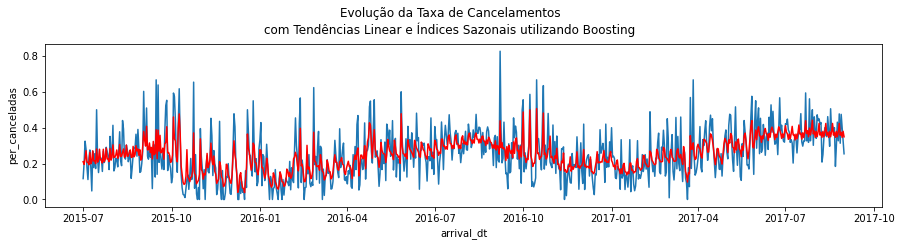

In [103]:
tb_resort_ts_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_resort_ts_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
);


## Fazendo previsões

In [109]:
tb_resort_ts_b = tb_resort_ts.copy()
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)

ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
dummy_names = list(ohe_fit.get_feature_names_out())
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(tb_resort_ts_b[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts_b[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

final_list = spl_names + dummy_names + ["t_dias"]
X = tb_resort_ts_b[final_list]
y = tb_resort_ts_b['per_canceladas']
scaler = StandardScaler()
scaler.fit(X)
cat_fit = cat.CatBoostRegressor(iterations=1708, depth=9)
cat_fit.fit(scaler.transform(X), y)


Learning rate set to 0.024933
0:	learn: 0.1352815	total: 14.8ms	remaining: 25.3s
1:	learn: 0.1345918	total: 23ms	remaining: 19.6s
2:	learn: 0.1338301	total: 31.7ms	remaining: 18s
3:	learn: 0.1331401	total: 37.6ms	remaining: 16s
4:	learn: 0.1323345	total: 43.1ms	remaining: 14.7s
5:	learn: 0.1316754	total: 49.6ms	remaining: 14.1s
6:	learn: 0.1308809	total: 57.8ms	remaining: 14.1s
7:	learn: 0.1302915	total: 64ms	remaining: 13.6s
8:	learn: 0.1297133	total: 70.3ms	remaining: 13.3s
9:	learn: 0.1291181	total: 76.4ms	remaining: 13s
10:	learn: 0.1286108	total: 83.3ms	remaining: 12.9s
11:	learn: 0.1279566	total: 90ms	remaining: 12.7s
12:	learn: 0.1273943	total: 96.3ms	remaining: 12.6s
13:	learn: 0.1268210	total: 102ms	remaining: 12.3s
14:	learn: 0.1263364	total: 108ms	remaining: 12.2s
15:	learn: 0.1258609	total: 114ms	remaining: 12.1s
16:	learn: 0.1253924	total: 120ms	remaining: 12s
17:	learn: 0.1248790	total: 128ms	remaining: 12s
18:	learn: 0.1244233	total: 134ms	remaining: 11.9s
19:	learn: 0.1

194:	learn: 0.0994837	total: 1.17s	remaining: 9.1s
195:	learn: 0.0994361	total: 1.18s	remaining: 9.1s
196:	learn: 0.0993381	total: 1.19s	remaining: 9.1s
197:	learn: 0.0992659	total: 1.19s	remaining: 9.09s
198:	learn: 0.0992021	total: 1.2s	remaining: 9.09s
199:	learn: 0.0991171	total: 1.21s	remaining: 9.09s
200:	learn: 0.0990217	total: 1.21s	remaining: 9.1s
201:	learn: 0.0989585	total: 1.22s	remaining: 9.11s
202:	learn: 0.0989030	total: 1.23s	remaining: 9.12s
203:	learn: 0.0988693	total: 1.24s	remaining: 9.13s
204:	learn: 0.0988136	total: 1.25s	remaining: 9.14s
205:	learn: 0.0987574	total: 1.25s	remaining: 9.13s
206:	learn: 0.0986817	total: 1.26s	remaining: 9.13s
207:	learn: 0.0986215	total: 1.27s	remaining: 9.14s
208:	learn: 0.0985609	total: 1.28s	remaining: 9.17s
209:	learn: 0.0984639	total: 1.29s	remaining: 9.18s
210:	learn: 0.0983827	total: 1.29s	remaining: 9.19s
211:	learn: 0.0983427	total: 1.3s	remaining: 9.18s
212:	learn: 0.0982629	total: 1.31s	remaining: 9.19s
213:	learn: 0.0981

368:	learn: 0.0891878	total: 2.15s	remaining: 7.81s
369:	learn: 0.0891332	total: 2.16s	remaining: 7.81s
370:	learn: 0.0890667	total: 2.17s	remaining: 7.8s
371:	learn: 0.0890478	total: 2.17s	remaining: 7.8s
372:	learn: 0.0889752	total: 2.18s	remaining: 7.8s
373:	learn: 0.0889129	total: 2.18s	remaining: 7.79s
374:	learn: 0.0888481	total: 2.19s	remaining: 7.78s
375:	learn: 0.0888057	total: 2.19s	remaining: 7.77s
376:	learn: 0.0887434	total: 2.2s	remaining: 7.77s
377:	learn: 0.0887209	total: 2.21s	remaining: 7.76s
378:	learn: 0.0886650	total: 2.21s	remaining: 7.76s
379:	learn: 0.0886001	total: 2.22s	remaining: 7.75s
380:	learn: 0.0885866	total: 2.22s	remaining: 7.74s
381:	learn: 0.0885737	total: 2.23s	remaining: 7.73s
382:	learn: 0.0884859	total: 2.23s	remaining: 7.73s
383:	learn: 0.0884083	total: 2.24s	remaining: 7.72s
384:	learn: 0.0883330	total: 2.25s	remaining: 7.72s
385:	learn: 0.0882493	total: 2.25s	remaining: 7.71s
386:	learn: 0.0881963	total: 2.26s	remaining: 7.7s
387:	learn: 0.088

540:	learn: 0.0806540	total: 3.15s	remaining: 6.79s
541:	learn: 0.0805996	total: 3.15s	remaining: 6.78s
542:	learn: 0.0805488	total: 3.16s	remaining: 6.78s
543:	learn: 0.0804829	total: 3.17s	remaining: 6.78s
544:	learn: 0.0804476	total: 3.17s	remaining: 6.77s
545:	learn: 0.0804043	total: 3.18s	remaining: 6.77s
546:	learn: 0.0803454	total: 3.19s	remaining: 6.76s
547:	learn: 0.0802813	total: 3.19s	remaining: 6.76s
548:	learn: 0.0802294	total: 3.2s	remaining: 6.75s
549:	learn: 0.0801769	total: 3.2s	remaining: 6.75s
550:	learn: 0.0801680	total: 3.21s	remaining: 6.74s
551:	learn: 0.0801317	total: 3.22s	remaining: 6.74s
552:	learn: 0.0801019	total: 3.22s	remaining: 6.73s
553:	learn: 0.0800415	total: 3.23s	remaining: 6.72s
554:	learn: 0.0800229	total: 3.23s	remaining: 6.71s
555:	learn: 0.0799613	total: 3.24s	remaining: 6.71s
556:	learn: 0.0799229	total: 3.24s	remaining: 6.7s
557:	learn: 0.0798763	total: 3.25s	remaining: 6.69s
558:	learn: 0.0798669	total: 3.25s	remaining: 6.68s
559:	learn: 0.0

722:	learn: 0.0727595	total: 4.13s	remaining: 5.63s
723:	learn: 0.0727420	total: 4.13s	remaining: 5.62s
724:	learn: 0.0727127	total: 4.14s	remaining: 5.61s
725:	learn: 0.0726459	total: 4.15s	remaining: 5.61s
726:	learn: 0.0726363	total: 4.15s	remaining: 5.6s
727:	learn: 0.0725844	total: 4.16s	remaining: 5.6s
728:	learn: 0.0725276	total: 4.16s	remaining: 5.59s
729:	learn: 0.0724865	total: 4.17s	remaining: 5.59s
730:	learn: 0.0724546	total: 4.17s	remaining: 5.58s
731:	learn: 0.0724197	total: 4.18s	remaining: 5.57s
732:	learn: 0.0724039	total: 4.18s	remaining: 5.56s
733:	learn: 0.0723404	total: 4.19s	remaining: 5.56s
734:	learn: 0.0723255	total: 4.19s	remaining: 5.55s
735:	learn: 0.0723173	total: 4.2s	remaining: 5.54s
736:	learn: 0.0722643	total: 4.2s	remaining: 5.54s
737:	learn: 0.0722368	total: 4.21s	remaining: 5.53s
738:	learn: 0.0722211	total: 4.22s	remaining: 5.53s
739:	learn: 0.0721873	total: 4.23s	remaining: 5.53s
740:	learn: 0.0721461	total: 4.23s	remaining: 5.52s
741:	learn: 0.07

894:	learn: 0.0667422	total: 5.12s	remaining: 4.65s
895:	learn: 0.0667058	total: 5.12s	remaining: 4.64s
896:	learn: 0.0666672	total: 5.13s	remaining: 4.64s
897:	learn: 0.0666384	total: 5.13s	remaining: 4.63s
898:	learn: 0.0665927	total: 5.14s	remaining: 4.63s
899:	learn: 0.0665732	total: 5.15s	remaining: 4.62s
900:	learn: 0.0665318	total: 5.15s	remaining: 4.61s
901:	learn: 0.0665195	total: 5.16s	remaining: 4.61s
902:	learn: 0.0664826	total: 5.17s	remaining: 4.6s
903:	learn: 0.0664497	total: 5.17s	remaining: 4.6s
904:	learn: 0.0664052	total: 5.18s	remaining: 4.59s
905:	learn: 0.0663759	total: 5.18s	remaining: 4.59s
906:	learn: 0.0663191	total: 5.19s	remaining: 4.58s
907:	learn: 0.0663134	total: 5.19s	remaining: 4.57s
908:	learn: 0.0662742	total: 5.2s	remaining: 4.57s
909:	learn: 0.0662420	total: 5.2s	remaining: 4.56s
910:	learn: 0.0662040	total: 5.21s	remaining: 4.55s
911:	learn: 0.0661910	total: 5.21s	remaining: 4.55s
912:	learn: 0.0661631	total: 5.22s	remaining: 4.54s
913:	learn: 0.06

1068:	learn: 0.0612427	total: 6.1s	remaining: 3.65s
1069:	learn: 0.0611982	total: 6.1s	remaining: 3.64s
1070:	learn: 0.0611848	total: 6.11s	remaining: 3.63s
1071:	learn: 0.0611451	total: 6.11s	remaining: 3.63s
1072:	learn: 0.0611130	total: 6.12s	remaining: 3.62s
1073:	learn: 0.0610712	total: 6.13s	remaining: 3.62s
1074:	learn: 0.0610436	total: 6.13s	remaining: 3.61s
1075:	learn: 0.0610344	total: 6.14s	remaining: 3.6s
1076:	learn: 0.0610178	total: 6.14s	remaining: 3.6s
1077:	learn: 0.0610119	total: 6.15s	remaining: 3.59s
1078:	learn: 0.0609545	total: 6.15s	remaining: 3.59s
1079:	learn: 0.0609184	total: 6.16s	remaining: 3.58s
1080:	learn: 0.0608851	total: 6.16s	remaining: 3.58s
1081:	learn: 0.0608729	total: 6.17s	remaining: 3.57s
1082:	learn: 0.0608678	total: 6.18s	remaining: 3.56s
1083:	learn: 0.0608389	total: 6.18s	remaining: 3.56s
1084:	learn: 0.0608179	total: 6.19s	remaining: 3.55s
1085:	learn: 0.0607951	total: 6.19s	remaining: 3.55s
1086:	learn: 0.0607854	total: 6.2s	remaining: 3.54

1243:	learn: 0.0566534	total: 7.08s	remaining: 2.64s
1244:	learn: 0.0566418	total: 7.09s	remaining: 2.64s
1245:	learn: 0.0566050	total: 7.09s	remaining: 2.63s
1246:	learn: 0.0565729	total: 7.1s	remaining: 2.63s
1247:	learn: 0.0565376	total: 7.11s	remaining: 2.62s
1248:	learn: 0.0565178	total: 7.12s	remaining: 2.61s
1249:	learn: 0.0565095	total: 7.12s	remaining: 2.61s
1250:	learn: 0.0564921	total: 7.13s	remaining: 2.6s
1251:	learn: 0.0564824	total: 7.13s	remaining: 2.6s
1252:	learn: 0.0564604	total: 7.14s	remaining: 2.59s
1253:	learn: 0.0564141	total: 7.15s	remaining: 2.59s
1254:	learn: 0.0563856	total: 7.15s	remaining: 2.58s
1255:	learn: 0.0563604	total: 7.16s	remaining: 2.58s
1256:	learn: 0.0563320	total: 7.16s	remaining: 2.57s
1257:	learn: 0.0562983	total: 7.17s	remaining: 2.56s
1258:	learn: 0.0562825	total: 7.17s	remaining: 2.56s
1259:	learn: 0.0562747	total: 7.18s	remaining: 2.55s
1260:	learn: 0.0562459	total: 7.18s	remaining: 2.55s
1261:	learn: 0.0562297	total: 7.19s	remaining: 2.

1423:	learn: 0.0526419	total: 8.07s	remaining: 1.61s
1424:	learn: 0.0526158	total: 8.07s	remaining: 1.6s
1425:	learn: 0.0525905	total: 8.08s	remaining: 1.6s
1426:	learn: 0.0525668	total: 8.09s	remaining: 1.59s
1427:	learn: 0.0525495	total: 8.09s	remaining: 1.59s
1428:	learn: 0.0525178	total: 8.1s	remaining: 1.58s
1429:	learn: 0.0525041	total: 8.1s	remaining: 1.57s
1430:	learn: 0.0524791	total: 8.11s	remaining: 1.57s
1431:	learn: 0.0524761	total: 8.11s	remaining: 1.56s
1432:	learn: 0.0524656	total: 8.12s	remaining: 1.56s
1433:	learn: 0.0524541	total: 8.12s	remaining: 1.55s
1434:	learn: 0.0524456	total: 8.13s	remaining: 1.55s
1435:	learn: 0.0524070	total: 8.13s	remaining: 1.54s
1436:	learn: 0.0523921	total: 8.14s	remaining: 1.53s
1437:	learn: 0.0523649	total: 8.14s	remaining: 1.53s
1438:	learn: 0.0523403	total: 8.15s	remaining: 1.52s
1439:	learn: 0.0523251	total: 8.16s	remaining: 1.52s
1440:	learn: 0.0522979	total: 8.16s	remaining: 1.51s
1441:	learn: 0.0522833	total: 8.17s	remaining: 1.5

1600:	learn: 0.0492316	total: 9.06s	remaining: 605ms
1601:	learn: 0.0492247	total: 9.07s	remaining: 600ms
1602:	learn: 0.0492107	total: 9.07s	remaining: 594ms
1603:	learn: 0.0491961	total: 9.08s	remaining: 589ms
1604:	learn: 0.0491893	total: 9.09s	remaining: 583ms
1605:	learn: 0.0491719	total: 9.09s	remaining: 577ms
1606:	learn: 0.0491633	total: 9.1s	remaining: 572ms
1607:	learn: 0.0491473	total: 9.1s	remaining: 566ms
1608:	learn: 0.0491249	total: 9.11s	remaining: 560ms
1609:	learn: 0.0490970	total: 9.11s	remaining: 555ms
1610:	learn: 0.0490617	total: 9.12s	remaining: 549ms
1611:	learn: 0.0490368	total: 9.13s	remaining: 543ms
1612:	learn: 0.0490261	total: 9.13s	remaining: 538ms
1613:	learn: 0.0489988	total: 9.13s	remaining: 532ms
1614:	learn: 0.0489819	total: 9.14s	remaining: 526ms
1615:	learn: 0.0489549	total: 9.14s	remaining: 521ms
1616:	learn: 0.0489349	total: 9.15s	remaining: 515ms
1617:	learn: 0.0489127	total: 9.15s	remaining: 509ms
1618:	learn: 0.0488863	total: 9.16s	remaining: 5

In [114]:
X_pred = range(int(max(X['t_dias'])), int(max(X['t_dias'])) + 31)
min_date = min(tb_resort_ts_b['arrival_dt'])
tb_pred = pd.DataFrame({'t_dias' : X_pred})
tb_pred['arrival_dt'] = pd.to_timedelta(tb_pred['t_dias'], 'd') + min_date

In [115]:
tb_pred

,t_dias,arrival_dt
0,792,2017-08-31
1,793,2017-09-01
2,794,2017-09-02
3,795,2017-09-03
4,796,2017-09-04
5,797,2017-09-05
6,798,2017-09-06
7,799,2017-09-07
8,800,2017-09-08
9,801,2017-09-09


In [118]:
X_pred = range(int(max(X['t_dias'])), int(max(X['t_dias'])) + 31)
min_date = min(tb_resort_ts_b['arrival_dt'])
tb_pred = pd.DataFrame({'t_dias' : X_pred})
tb_pred['arrival_dt'] = pd.to_timedelta(tb_pred['t_dias'], 'd') + min_date
tb_pred["mes"] = tb_pred["arrival_dt"].dt.month.astype(str)
tb_pred["dia_semana"] = tb_pred["arrival_dt"].dt.weekday.astype(str)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            ohe_fit.transform(tb_pred[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            spl_trans.transform(tb_pred[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

In [119]:
tb_pred

,t_dias,arrival_dt,mes,dia_semana,mes_10,mes_11,mes_12,mes_2,mes_3,mes_4,...,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25
0,792,2017-08-31,8,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
1,793,2017-09-01,9,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
2,794,2017-09-02,9,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
3,795,2017-09-03,9,6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
4,796,2017-09-04,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
5,797,2017-09-05,9,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
6,798,2017-09-06,9,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
7,799,2017-09-07,9,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
8,800,2017-09-08,9,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
9,801,2017-09-09,9,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667


In [125]:
tb_pred['pred'] = cat_fit.predict(scaler.transform(tb_pred[final_list]))

In [130]:
tb_pred['lim_inf_cancelamento'] = tb_pred['pred'] - 0.076
tb_pred['lim_sup_cancelamento'] = tb_pred['pred'] + 0.076

In [131]:
tb_pred[['arrival_dt', 'pred', 'lim_inf_cancelamento', 'lim_sup_cancelamento']]

,arrival_dt,pred,lim_inf_cancelamento,lim_sup_cancelamento
0,2017-08-31,0.299724,0.223724,0.375724
1,2017-09-01,0.311109,0.235109,0.387109
2,2017-09-02,0.339515,0.263515,0.415515
3,2017-09-03,0.290124,0.214124,0.366124
4,2017-09-04,0.297714,0.221714,0.373714
5,2017-09-05,0.255382,0.179382,0.331382
6,2017-09-06,0.311264,0.235264,0.387264
7,2017-09-07,0.280792,0.204792,0.356792
8,2017-09-08,0.311109,0.235109,0.387109
9,2017-09-09,0.339515,0.263515,0.415515


## Exercício para tarde

No modelo de boosting acima utilizamos apenas as variáveis de spline, o componente linear e a as dummies sazonais. Será que conseguimos adicionar variáveis sazonais continuas ao modelo acima? Quais períodos deveriamos utilizar para essas variáveis? Crie uma rotina que permita o teste rápido de permutações entre os diferentes componentes temporais que vimos até agora e utilize-a para decidir quais o melhor conjunto de variáveis para o nosso modelo.

# Processos Auto-regressivos

## Autocorrelação e Autocorrelação Parcial

In [ ]:
tb_resort_ts_d["resid"] = (
    tb_resort_ts_d["per_canceladas"] - tb_resort_ts_d["pred_boosting"]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="resid")
fig.suptitle(
    f"Evolução dos Resíduos\nModelo de Boosting",
    y=1.05,
)


In [ ]:
tb_resort_ts_d["resid_lag"] = tb_resort_ts_d["resid"].shift(3)
tb_resort_ts_d[["resid", "resid_lag"]].head()


In [ ]:
sns.lmplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="resid_lag",
    y="resid",
)
fig.suptitle(f"Diagrama de Fase dos Resíduos\n L=1", y=1.05)


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
plot_acf(tb_resort_ts_d["resid"], lags = range(1, 15));

In [ ]:
plot_pacf(tb_resort_ts_d["resid"], lags = range(1, 15), method = 'ywm');

## Os métodos Shift e Diff

Uma forma de tratar a auto-correlação é utilizar o histórico da propria variável modelada como variável de entrada. Podemos fazer isso neutralizando essa autocorrelação através da diferenças (Hoje - Ontem), ou então adicionar a variável *Ontem* ao modelo. **Devemos tomar cuidado pois isso muda o horizonte preditivo de nosso modelo!!**

In [ ]:
plot_acf(tb_resort_ts_d["per_canceladas"], lags = range(1, 15));

In [ ]:
tb_resort_ts_d[['per_canceladas']].diff().dropna()

In [ ]:
plot_acf(tb_resort_ts_d[['per_canceladas']].diff().dropna(), lags = range(1, 15));

## Modelos **A**(uto)**R**(egressive)**I**(ntegrated)**M**(oving)**A**(average)

Os modelos ARIMA são modelos lineares que incorporam as idéias apresentadas acima em um framework único de modelagem.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model = ARIMA(train_data['per_canceladas'], exog = train_data[dummy_names], order = (1,0,1))
arima_fit = arima_model.fit()
arima_fit.summary()

In [ ]:
tb_resort_ts_d['pred_arima'] = arima_fit.predict(exog = test_data[dummy_names])